# Load raster data via WMS

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from owslib.util import Authentication
from owslib.wms import WebMapService

import geoengine as ge

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030/api")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
User Id:             36c6c0f9-827a-4343-8ed9-29bf434b8492
Session Id:          a3becc41-488a-4341-96b3-6c66de26e97b
Session valid until: 2025-09-11T09:19:50.659Z

## Define workflow of MODIS NDVI raster

In [4]:
workflow = ge.register_workflow({"type": "Raster", "operator": {"type": "GdalSource", "params": {"data": "ndvi"}}})
workflow

1e415c9c-55f3-51a2-b50b-b5053d1debbb

## Query raster via WMS and Cartopy

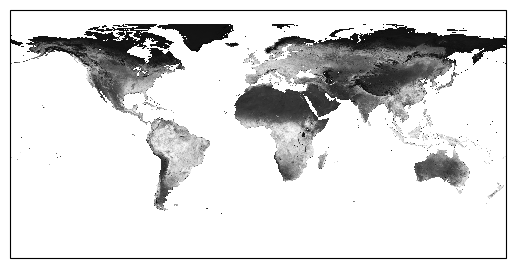

In [5]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangleWithResolution(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1),
)

wms = WebMapService(
    f"{session.server_url}/wms/{str(workflow)}",
    version="1.3.0",
    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
    timeout=3600,
)

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_wms(
    wms,
    layers=[str(workflow)],
    wms_kwargs={
        "time": bbox.time_str,
        "crs": bbox.srs,
    },
)

ax.set_xlim(bbox.spatial_bounds.xmin, bbox.spatial_bounds.xmax)
ax.set_ylim(bbox.spatial_bounds.ymin, bbox.spatial_bounds.ymax)

plt.show()

## Query as image with colorizer option

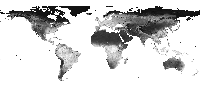

In [6]:
time = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")

workflow.wms_get_map_as_image(
    ge.QueryRectangleWithResolution(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1.8, 1.8),
    ),
    raster_colorizer=ge.SingleBandRasterColorizer(
        band=0, band_colorizer=ge.colorizer.Colorizer.linear_with_mpl_cmap(color_map="gray", min_max=(0, 255))
    ),
)

## Query dataframe of point data

In [7]:
ports = ge.register_workflow(
    {
        "type": "Vector",
        "operator": {"type": "OgrSource", "params": {"data": "ne_10m_ports", "attributeProjection": None}},
    }
)

time = datetime.strptime("2014-04-01T12:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z")

df = ports.get_dataframe(
    ge.QueryRectangleWithResolution(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        ge.SpatialResolution(0.1, 0.1)
    )
)

df.head()

,geometry,name,scalerank,featurecla,natlscale,website,start,end
0,POINT (-69.92356 12.4375),Sint Nicolaas,8,Port,5.0,www.rocargo.com/SanNicolas.html,NaT,NaT
1,POINT (-58.95141 -34.15333),Campana,8,Port,5.0,www.consejoportuario.com.ar,NaT,NaT
2,POINT (-59.00495 -34.09889),Zarate,8,Port,5.0,www.consejoportuario.com.ar,NaT,NaT
3,POINT (-62.10088 -38.89444),Puerto Belgrano/Bahia Blanca,8,Port,5.0,None,NaT,NaT
4,POINT (-62.30053 -38.78306),Puerto Galvan/Bahia Blanca,8,Port,5.0,None,NaT,NaT


## Query whole world and combine with points

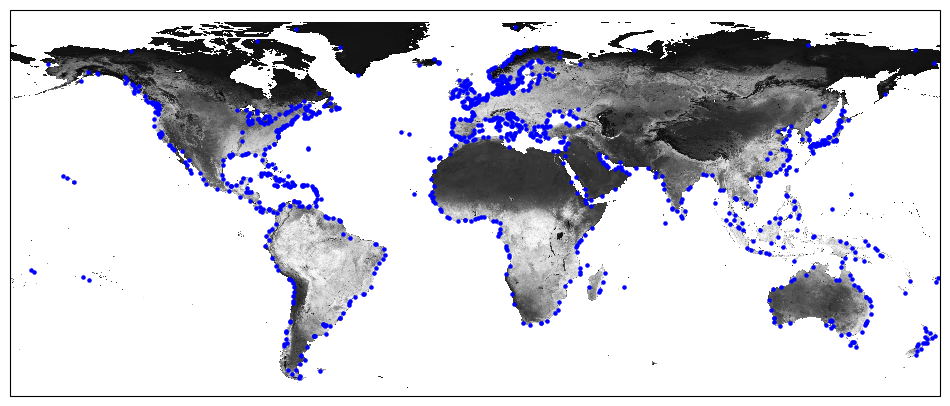

In [8]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangleWithResolution(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1)
)

wms = WebMapService(
    f"{session.server_url}/wms/{str(workflow)}",
    version="1.3.0",
    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
    timeout=3600,
)

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())

plt.gca().add_wms(wms, layers=[str(workflow)], wms_kwargs={"time": bbox.time_str, "crs": bbox.srs})

df.plot(markersize=5, marker="o", color="blue", ax=plt.gca())

plt.show()

## Query part of the world and combine with points

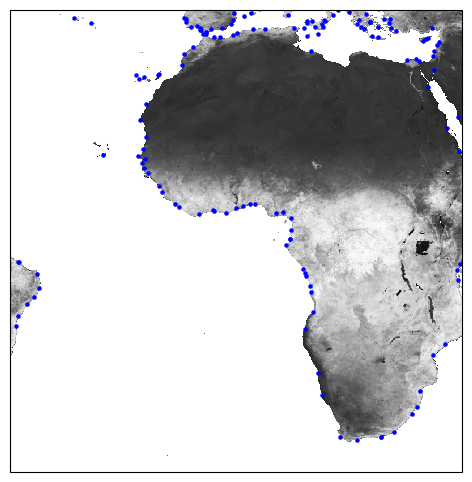

In [9]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangleWithResolution(
    ge.BoundingBox2D(-40.0, -40.0, 40.0, 40.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1)
)

wms = WebMapService(
    f"{session.server_url}/wms/{str(workflow)}",
    version="1.3.0",
    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
    timeout=3600,
)

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())

plt.gca().add_wms(wms, layers=[str(workflow)], wms_kwargs={"time": bbox.time_str, "crs": bbox.srs})

df.plot(markersize=5, marker="o", color="blue", ax=plt.gca())

plt.gca().set_xlim(bbox.spatial_bounds.xmin, bbox.spatial_bounds.xmax)
plt.gca().set_ylim(bbox.spatial_bounds.ymin, bbox.spatial_bounds.ymax)

plt.show()